In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    precision_recall_fscore_support,
)

import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "datasets/"

student_info = pd.read_csv(
    DATA_DIR + "studentInfo.csv",
    usecols=[
        "id_student",
        "code_module",
        "code_presentation",
        "final_result",
        "gender",
        "region",
        "age_band",
        "highest_education",
        "imd_band",
        "num_of_prev_attempts",
        "studied_credits",
    ],
)

student_reg = pd.read_csv(
    DATA_DIR + "studentRegistration.csv",
    usecols=[
        "id_student",
        "code_module",
        "code_presentation",
        "date_registration",
        "date_unregistration",
    ],
)

student_vle = pd.read_csv(
    DATA_DIR + "studentVle.csv",
    usecols=[
        "id_student",
        "code_module",
        "code_presentation",
        "id_site",
        "date",
        "sum_click",
    ],
)

student_ass = pd.read_csv(
    DATA_DIR + "studentAssessment.csv",
    usecols=[
        "id_assessment",
        "id_student",
        "date_submitted",
        "is_banked",
        "score",
    ],
)

In [3]:
MODULE = "EEE"
PRESENTATION = "2014J"
EARLY_DAYS = 100  # lấy dữ liệu 100 ngày đầu

students = student_info[
    (student_info["code_module"] == MODULE)
    & (student_info["code_presentation"] == PRESENTATION)
].copy()

# Label: Withdrawn = dropout (1), còn lại = 0
students["dropout"] = np.where(students["final_result"] == "Withdrawn", 1, 0)

print("Số lượng sinh viên:", len(students))
print("Tỉ lệ dropout:", students["dropout"].mean())

Số lượng sinh viên: 1188
Tỉ lệ dropout: 0.25757575757575757


In [4]:
reg = student_reg[
    (student_reg["code_module"] == MODULE)
    & (student_reg["code_presentation"] == PRESENTATION)
    & (student_reg["id_student"].isin(students["id_student"]))
].copy()

# Ngày đăng ký (cùng scale với OULAD: ngày tương đối so với bắt đầu khóa)
reg_features = reg[["id_student", "date_registration"]].copy()
reg_features = reg_features.rename(columns={"date_registration": "reg_day"})

# Đăng ký sớm (trước ngày 0) hay muộn
reg_features["registered_before_start"] = (reg_features["reg_day"] < 0).astype(int)

In [5]:
vle = student_vle[
    (student_vle["code_module"] == MODULE)
    & (student_vle["code_presentation"] == PRESENTATION)
    & (student_vle["id_student"].isin(students["id_student"]))
    & (student_vle["date"] >= 0)
    & (student_vle["date"] <= EARLY_DAYS)
].copy()

# Tổng quan
vle_agg = (
    vle.groupby("id_student")
    .agg(
        total_clicks=("sum_click", "sum"),
        active_days=("date", "nunique"),
    )
    .reset_index()
)
vle_agg["avg_clicks_per_day"] = vle_agg["total_clicks"] / EARLY_DAYS
vle_agg["avg_clicks_per_active_day"] = vle_agg["total_clicks"] / vle_agg["active_days"].replace(0, np.nan)
vle_agg["avg_clicks_per_active_day"] = vle_agg["avg_clicks_per_active_day"].fillna(0)

# Click theo từng giai đoạn (để giống style “milestones” trong bài viết)
def clicks_in_window(df, start_day, end_day, col_name):
    w = (
        df[(df["date"] >= start_day) & (df["date"] <= end_day)]
        .groupby("id_student")["sum_click"]
        .sum()
        .reset_index()
        .rename(columns={"sum_click": col_name})
    )
    return w

w1 = clicks_in_window(vle, 0, 7, "clicks_0_7")
w2 = clicks_in_window(vle, 8, 14, "clicks_8_14")
w3 = clicks_in_window(vle, 15, 28, "clicks_15_28")
w4 = clicks_in_window(vle, 29, EARLY_DAYS, f"clicks_29_{EARLY_DAYS}")

# Merge các window vào vle_agg
for w in [w1, w2, w3, w4]:
    vle_agg = vle_agg.merge(w, on="id_student", how="left")

vle_agg = vle_agg.fillna(0)


In [6]:
ass = student_ass[
    (student_ass["id_student"].isin(students["id_student"]))
    & (student_ass["date_submitted"] >= 0)
    & (student_ass["date_submitted"] <= EARLY_DAYS)
].copy()

ass_agg = (
    ass.groupby("id_student")
    .agg(
        num_assessments=("id_assessment", "nunique"),
        avg_score=("score", "mean"),
        max_score=("score", "max"),
        min_score=("score", "min"),
        score_std=("score", "std"),
    )
    .reset_index()
)

# last_score theo ngày nộp
last_score = (
    ass.sort_values(["id_student", "date_submitted"])
    .groupby("id_student")["score"]
    .last()
    .reset_index()
    .rename(columns={"score": "last_score"})
)

ass_agg = ass_agg.merge(last_score, on="id_student", how="left")
ass_agg = ass_agg.fillna(0)

In [7]:
data = (
    students.merge(reg_features, on="id_student", how="left")
    .merge(vle_agg, on="id_student", how="left")
    .merge(ass_agg, on="id_student", how="left")
)

# Fill NaN cho numeric
numeric_cols_to_fill = [
    "reg_day",
    "registered_before_start",
    "total_clicks",
    "active_days",
    "avg_clicks_per_day",
    "avg_clicks_per_active_day",
    "clicks_0_7",
    "clicks_8_14",
    "clicks_15_28",
    f"clicks_29_{EARLY_DAYS}",
    "num_of_prev_attempts",
    "studied_credits",
    "num_assessments",
    "avg_score",
    "max_score",
    "min_score",
    "score_std",
    "last_score",
]
for col in numeric_cols_to_fill:
    data[col] = data[col].fillna(0)

print("NaN còn lại:")
print(data.isna().sum())

NaN còn lại:
code_module                   0
code_presentation             0
id_student                    0
gender                        0
region                        0
highest_education             0
imd_band                     47
age_band                      0
num_of_prev_attempts          0
studied_credits               0
final_result                  0
dropout                       0
reg_day                       0
registered_before_start       0
total_clicks                  0
active_days                   0
avg_clicks_per_day            0
avg_clicks_per_active_day     0
clicks_0_7                    0
clicks_8_14                   0
clicks_15_28                  0
clicks_29_100                 0
num_assessments               0
avg_score                     0
max_score                     0
min_score                     0
score_std                     0
last_score                    0
dtype: int64


In [8]:
feature_cols_num = [
    "total_clicks",
    "active_days",
    "avg_clicks_per_day",
    "avg_clicks_per_active_day",
    "clicks_0_7",
    # "clicks_8_14",
    # "clicks_15_28",
    "num_assessments",
    "avg_score",
    "max_score",
    "min_score",
    "score_std",
    "last_score",
]


feature_cols_cat = [
    "gender",
    "age_band",
    "highest_education",
]


X = data[feature_cols_num + feature_cols_cat]
y = data["dropout"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

print("Shape train/test:", X_train.shape, X_test.shape)
print("Dropout ratio train/test:", y_train.mean(), y_test.mean())

Shape train/test: (831, 14) (357, 14)
Dropout ratio train/test: 0.2575210589651023 0.25770308123249297


In [9]:
X_train.head(5)

,total_clicks,active_days,avg_clicks_per_day,avg_clicks_per_active_day,clicks_0_7,num_assessments,avg_score,max_score,min_score,score_std,last_score,gender,age_band,highest_education
375,363.0,21.0,3.63,17.285714,26.0,2.0,81.0,86.0,76.0,7.071068,86.0,M,0-35,Lower Than A Level
806,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,M,0-35,Lower Than A Level
898,469.0,28.0,4.69,16.750000,27.0,2.0,90.0,96.0,84.0,8.485281,84.0,M,0-35,Lower Than A Level
1146,1625.0,38.0,16.25,42.763158,42.0,2.0,96.0,99.0,93.0,4.242641,99.0,M,0-35,HE Qualification
790,919.0,33.0,9.19,27.848485,35.0,2.0,96.5,97.0,96.0,0.707107,96.0,M,0-35,A Level or Equivalent


In [10]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat),
    ]
)

In [11]:
models = {
    "LogisticRegression": LogisticRegression(
        penalty="l1",
        solver="saga",
        tol=1e-4,
        max_iter=1200,
    ),
    "RandomForest": RandomForestClassifier(
        criterion="gini",
        max_depth=3,
        min_samples_leaf=10,
        min_samples_split=50,
        n_estimators=50,
    ),
    "GradientBoosting": GradientBoostingClassifier(
        learning_rate=0.03,
        max_depth=3,
        min_samples_split=20,
        n_estimators=10,
        n_iter_no_change=10,
    ),
    "MLPClassifier": MLPClassifier(
        alpha=0.1,
        early_stopping=True,
        hidden_layer_sizes=(135,),
        learning_rate="constant",
        learning_rate_init=0.3,
        max_iter=1200,
        momentum=0.9,
        solver="sgd",
    ),
}

In [15]:
from sklearn.metrics import precision_recall_curve, roc_curve, ConfusionMatrixDisplay

results = {}
y_test_dict = {}
y_pred_dict = {}
y_proba_dict = {}

for name, clf in models.items():
    print(f"\n===== Model: {name} =====")
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("classifier", clf),
        ]
    )

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision_1, recall_1, f1_1, support_1 = precision_recall_fscore_support(
        y_test, y_pred, labels=[1], average=None
    )
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)

    print("Accuracy:", accuracy)
    print("Precision (class 1):", precision_1[0])
    print("Recall (class 1):", recall_1[0])
    print("F1 (class 1):", f1_1[0])
    print("ROC AUC:", roc_auc)
    print("Average precision:", avg_prec)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    results[name] = {
        "accuracy": accuracy,
        "precision_1": precision_1[0],
        "recall_1": recall_1[0],
        "f1_1": f1_1[0],
        "roc_auc": roc_auc,
        "avg_precision": avg_prec,
        "support_1": support_1[0],
    }

    # Lưu lại để vẽ biểu đồ sau
    y_test_dict[name] = y_test
    y_pred_dict[name] = y_pred
    y_proba_dict[name] = y_proba

results_df = pd.DataFrame(results).T
results_df



===== Model: LogisticRegression =====
Accuracy: 0.896358543417367
Precision (class 1): 0.8873239436619719
Recall (class 1): 0.6847826086956522
F1 (class 1): 0.7730061349693251
ROC AUC: 0.9125922887612797
Average precision: 0.8009885329158

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       265
           1       0.89      0.68      0.77        92

    accuracy                           0.90       357
   macro avg       0.89      0.83      0.85       357
weighted avg       0.90      0.90      0.89       357


===== Model: RandomForest =====
Accuracy: 0.9019607843137255
Precision (class 1): 0.8701298701298701
Recall (class 1): 0.7282608695652174
F1 (class 1): 0.7928994082840237
ROC AUC: 0.9227850697292863
Average precision: 0.848453479440756

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       265
           1       0.87      0.73      

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Accuracy: 0.742296918767507
Precision (class 1): 0.0
Recall (class 1): 0.0
F1 (class 1): 0.0
ROC AUC: 0.9053732567678426
Average precision: 0.7802877039985615

Classification report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       265
           1       0.00      0.00      0.00        92

    accuracy                           0.74       357
   macro avg       0.37      0.50      0.43       357
weighted avg       0.55      0.74      0.63       357


===== Model: MLPClassifier =====
Accuracy: 0.896358543417367
Precision (class 1): 0.8481012658227848
Recall (class 1): 0.7282608695652174
F1 (class 1): 0.783625730994152
ROC AUC: 0.9272559474979492
Average precision: 0.8193113933862973

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       265
           1       0.85      0.73      0.78        92

    accuracy                           0.90       357
   macro av

,accuracy,precision_1,recall_1,f1_1,roc_auc,avg_precision,support_1
LogisticRegression,0.896359,0.887324,0.684783,0.773006,0.912592,0.800989,92.0
RandomForest,0.901961,0.870130,0.728261,0.792899,0.922785,0.848453,92.0
GradientBoosting,0.742297,0.000000,0.000000,0.000000,0.905373,0.780288,92.0
MLPClassifier,0.896359,0.848101,0.728261,0.783626,0.927256,0.819311,92.0


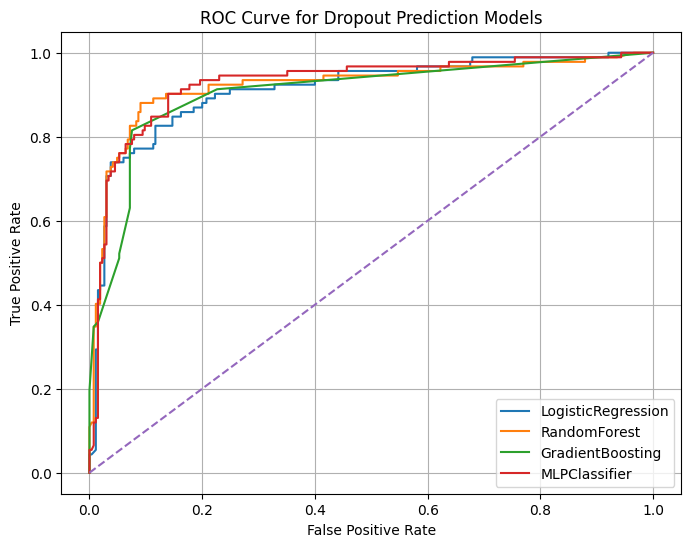

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for name, y_proba in y_proba_dict.items():
    fpr, tpr, _ = roc_curve(y_test_dict[name], y_proba)
    plt.plot(fpr, tpr, label=f"{name}")

plt.plot([0, 1], [0, 1], linestyle="--")  # đường random
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Dropout Prediction Models")
plt.legend()
plt.grid(True)
plt.show()


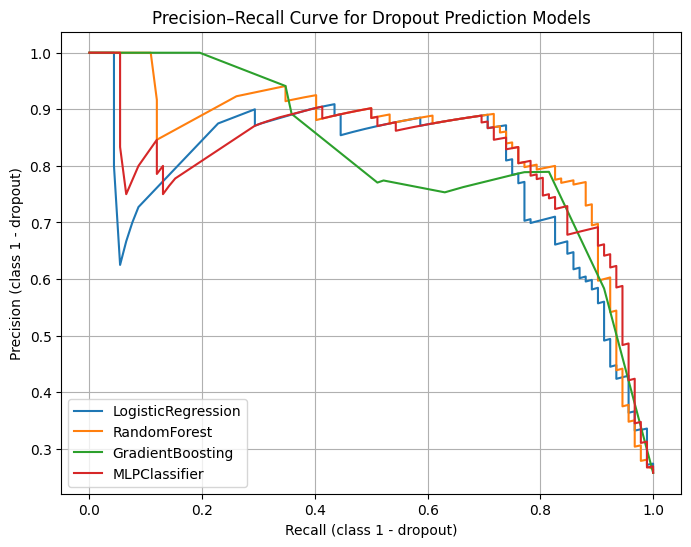

In [17]:
plt.figure(figsize=(8, 6))
for name, y_proba in y_proba_dict.items():
    precision, recall, _ = precision_recall_curve(y_test_dict[name], y_proba)
    plt.plot(recall, precision, label=f"{name}")

plt.xlabel("Recall (class 1 - dropout)")
plt.ylabel("Precision (class 1 - dropout)")
plt.title("Precision–Recall Curve for Dropout Prediction Models")
plt.legend()
plt.grid(True)
plt.show()


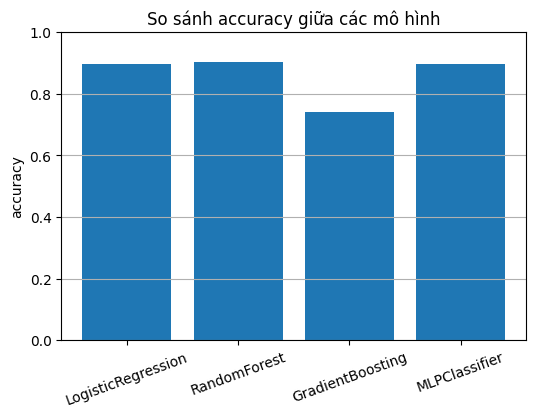

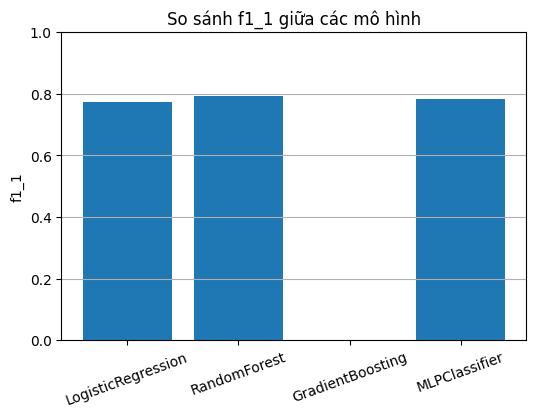

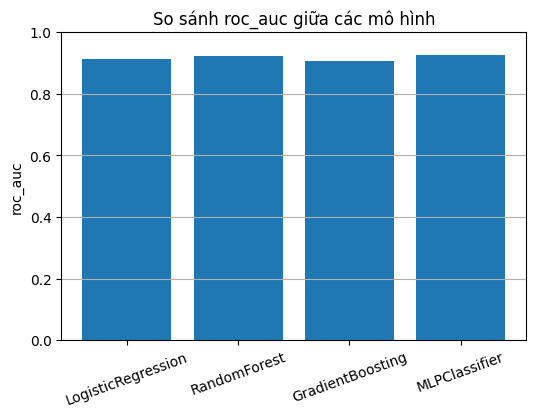

In [18]:
metrics_to_plot = ["accuracy", "f1_1", "roc_auc"]

for metric in metrics_to_plot:
    plt.figure(figsize=(6, 4))
    plt.bar(results_df.index, results_df[metric])
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.title(f"So sánh {metric} giữa các mô hình")
    plt.xticks(rotation=20)
    plt.grid(axis="y")
    plt.show()


<Figure size 500x500 with 0 Axes>

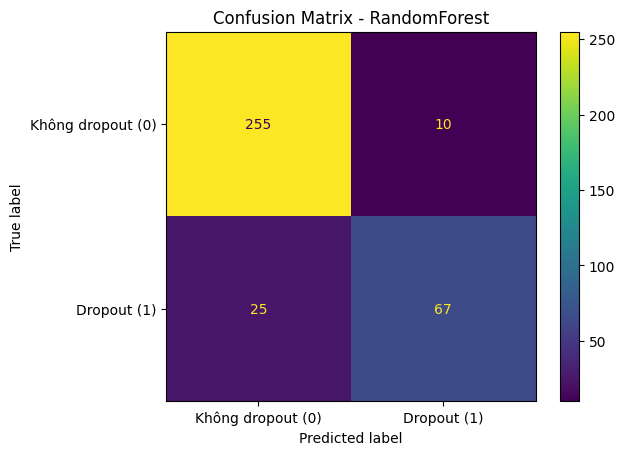

In [19]:
best_model_name = "RandomForest"  # theo bảng results_df của bạn

cm = confusion_matrix(y_test_dict[best_model_name], y_pred_dict[best_model_name])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Không dropout (0)", "Dropout (1)"],
)
plt.figure(figsize=(5, 5))
disp.plot(values_format="d")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()
